<a href="https://colab.research.google.com/github/rpimaster/OAI/blob/main/02-autoencoder/encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary

In [2]:
# architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.Sigmoid(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8, 3, 3)),
            nn.ConvTranspose2d(8, 8, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # apply encoder
        features = self.encoder(x)
        # apply decoder
        return self.decoder(features)
    def __str__(self):
        return str(self.encoder)+str(self.decoder)

In [3]:
autoencoder = Autoencoder()

In [4]:
!wget http://agentspace.org/download/pytorch_mnist_autoencoder_model.pth
model_name = 'pytorch_mnist_autoencoder_model.pth'
#from google.colab import files
#print('upload',model_name)
#files.upload()
autoencoder.load_state_dict(torch.load(model_name))

--2025-11-05 15:26:03--  http://agentspace.org/download/pytorch_mnist_autoencoder_model.pth
Resolving agentspace.org (agentspace.org)... 62.168.101.9
Connecting to agentspace.org (agentspace.org)|62.168.101.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.agentspace.org/download/pytorch_mnist_autoencoder_model.pth [following]
--2025-11-05 15:26:05--  https://www.agentspace.org/download/pytorch_mnist_autoencoder_model.pth
Resolving www.agentspace.org (www.agentspace.org)... 62.168.101.9
Connecting to www.agentspace.org (www.agentspace.org)|62.168.101.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52651 (51K)
Saving to: ‘pytorch_mnist_autoencoder_model.pth’

pytorch_mnist_autoe 100%[===================>]  51.42K   155KB/s    in 0.3s    

2025-11-05 15:26:06 (155 KB/s) - ‘pytorch_mnist_autoencoder_model.pth’ saved [52651/52651]



<All keys matched successfully>

In [6]:
device = 'cpu' # or 'cuda'
autoencoder.to(device)
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (13): Sigmoid()
    (14): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(8, 3, 3))
    (1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (4)

In [7]:
summary(autoencoder, input_size=(1,28,28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6            [-1, 8, 14, 14]           1,160
              ReLU-7            [-1, 8, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             584
              ReLU-9            [-1, 8, 14, 14]               0
        MaxPool2d-10              [-1, 8, 7, 7]               0
           Conv2d-11              [-1, 8, 5, 5]             584
             ReLU-12              [-1, 8, 5, 5]               0
           Conv2d-13              [-1, 8, 3, 3]             584
          Sigmoid-14              [-1, 

In [8]:
encoder = autoencoder.encoder
print(encoder)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU()
  (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (13): Sigmoid()
  (14): Flatten(start_dim=1, end_dim=-1)
)


In [9]:
# test dataloader and collect feature vectors for all test images from the dataset
batch_size = 512
test_loader = DataLoader(datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


In [10]:
feature_vectors = []
values = []
for batch, (x_test, y_test) in enumerate(test_loader):
    # send data to device
    inp = x_test.to(device)
    # forward pass to the model
    y = encoder(inp)
    feature_vectors.append(y.detach().cpu().numpy())
    values += list(y_test.detach().cpu().numpy())

In [11]:
feature_vectors = np.concatenate(feature_vectors)
print(feature_vectors.shape)

(10000, 72)


In [12]:
# display the latent space by drawing features vectors as points in the plane, colored according to their annotation
colors = { 0 : (0,0,255), 1 : (0,255,255), 2 : (0,255,0), 3 : (255,255,0), 4 : (255,255,255), 5: (160,160,160), 6: (255,0,0), 7: (255,0,255), 8: (80,80,0), 9 : (80,0,0) }

In [13]:
mean, eigenvectors = cv2.PCACompute(feature_vectors, np.mean(feature_vectors, axis=0).reshape(1,-1)) # PCA express feature vectors as mean + linear combination of eigenvectors

In [14]:
points = np.dot(feature_vectors-mean,eigenvectors.T)
points = points[:,:2] # reduce dimension 72 to 2
print(points.shape)

(10000, 2)


In [15]:
# visualize points in the plane
def display(points,types):
    m = np.max(np.abs(points))
    points = (points+m)/(2*m)
    v = 800
    graph = np.zeros((v,v,3),np.uint8)
    for i in range(len(points)):
        cv2.circle(graph,(int(v*points[i,0]),int(v*(1-points[i,1]))),2,colors[types[i]],cv2.FILLED)

    for j in range(10):
        cv2.rectangle(graph,(j*32,0),((j+1)*32,32),colors[j],cv2.FILLED)
        cv2.putText(graph,str(j),(j*32+8,32-8),0,0.9,(0,0,0))

    return graph

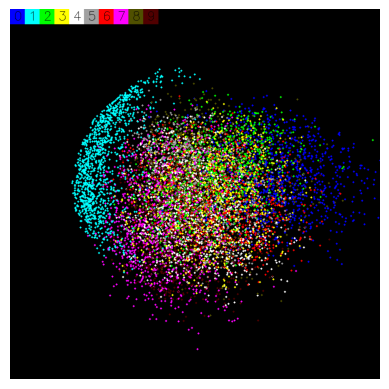

In [16]:
graph = display(points, values)
cv2.imwrite('latent-space.png',graph)
plt.imshow(graph)
plt.axis('off')
plt.show()

In [17]:
from google.colab import files
files.download('latent-space.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>